In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None) 


df = pd.read_pickle('/content/drive/MyDrive/Projets/allocine_dataset.pickle')
df_train = df['train_set']
df_val = df['val_set']
df_test = df['test_set']
df_test.head(1)

,film-url,review,polarity
0,http://www.allocine.fr/film/fichefilm-25385/critiques/spectateurs,"Magnifique épopée, une belle histoire, touchante avec des acteurs qui interprètent très bien leur rôles (Mel Gibson, Heath Ledger, Jason Isaacs...), le genre de film qui se savoure en famille! :)",1


## Recurrent neural network

Grâce à leur mémoire interne, les RNN peuvent se souvenir d'éléments importants concernant les données qu'ils ont reçues, ce qui leur permet d'être très précis dans la prédiction de ce qui va suivre. C'est pourquoi ils sont l'algorithme préféré pour les données séquentielles telles que les séries temporelles, la parole, le texte, les données financières, l'audio, la vidéo, la météo et bien plus encore.

En pratique, un LSTM est souvent utilisé, par opposition à un RNN standard, car il est plus efficace en termes de calcul. En fait, le LSTM a été introduit pour résoudre un problème dont souffrent les RNN standard, à savoir le problème du vanishing gradient.

Le problème principal est qu'il est trop difficile pour les RNN d'apprendre à préserver l'information sur de nombreux "pas temporels". Dans un RNN classique, l'état caché est constamment réécrit.

Ainsi, les LSTM et les GRU utilisent une cellule mémoire pour stocker la valeur d'activation des mots précédents dans les longues séquences. Le concept de portes entre maintenant en jeu. Les portes sont utilisées pour contrôler le flux d'informations dans le réseau. Les portes sont capables d'apprendre quelles entrées de la séquence sont importantes et de stocker leurs informations dans l'unité de mémoire. Elles peuvent transmettre les informations des longues séquences et les utiliser pour faire des prédictions.

Ici, on ne va donc pas implémenter une RNN standard mais un GRU puis un LSTM.

### Preprocessing

Le preprocessing est similaire à celui réalisé pour les word embbedings.

In [3]:
from gensim.utils import simple_preprocess

# Tokenize the text column to get the new column 'tokenized_text'
df_train['tk_review'] = df_train['review'].apply(lambda x : simple_preprocess(x)) 
df_val['tk_review'] = df_val['review'].apply(lambda x : simple_preprocess(x)) 
df_test['tk_review'] = df_test['review'].apply(lambda x : simple_preprocess(x)) 

Maintenant que le texte est nettoyé, nous pouvons procéder à l'encodage de celui-ci. On entraîne le tokenizer sur le train set puis on l'applique sur tous les jeux de données.



In [4]:
import tensorflow as tf

# tweak this params to get better results
MAX_NB_WORDS = 50000

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=MAX_NB_WORDS,
    oov_token="<unk>",
)
tokenizer.fit_on_texts(df_train['review'])

word_index = tokenizer.word_index
print("Found {} unique tokens.".format(len(word_index)))

Found 186308 unique tokens.


In [5]:
train_reviews_tokenized = tokenizer.texts_to_sequences(df_train['review'])
val_reviews_tokenized = tokenizer.texts_to_sequences(df_val['review'])
test_reviews_tokenized = tokenizer.texts_to_sequences(df_test['review'])

On réalise ensuite le padding des reviews selon un certain threshold (se basant sur de la distribution des longueurs moyennes des reviews)

In [6]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_LEN = 350

X_train = pad_sequences(train_reviews_tokenized, maxlen=MAX_LEN, padding='post')
X_val = pad_sequences(val_reviews_tokenized, maxlen=MAX_LEN, padding='post')
X_test = pad_sequences(test_reviews_tokenized, maxlen=MAX_LEN, padding='post')

y_train = np.array(df_train['polarity'])
y_val = np.array(df_val['polarity'])
y_test = np.array(df_test['polarity'])

### Modélisation

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense


# tweak this params to get better results
MAX_NB_WORDS = 50000

model = Sequential(name='RNN')

# Embedding layer is learning the embedding of words
#  before feeding it to the RNN layers
model.add(Embedding(MAX_NB_WORDS, 256,
                    mask_zero=True, input_shape=[None]))

# A RNN layer can also return the entire sequence of outputs for each sample 
# (one vector per timestep per sample), if you set return_sequences=True
model.add(GRU(256, return_sequences=True))
model.add(GRU(256))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [9]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Projets/rnn_weights.hdf5',
    save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=4, batch_size=64, 
    callbacks=[callback], verbose=1
)

Epoch 1/4
2500/2500 [==============================] - ETA: 0s - loss: 0.1819 - accuracy: 0.9292
Epoch 1: val_loss improved from inf to 0.15087, saving model to /content/drive/MyDrive/Projets/rnn_weights.hdf5
2500/2500 [==============================] - 124s 50ms/step - loss: 0.1819 - accuracy: 0.9292 - val_loss: 0.1509 - val_accuracy: 0.9420
Epoch 2/4
2499/2500 [============================>.] - ETA: 0s - loss: 0.0959 - accuracy: 0.9650
Epoch 2: val_loss did not improve from 0.15087
2500/2500 [==============================] - 133s 53ms/step - loss: 0.0959 - accuracy: 0.9650 - val_loss: 0.1534 - val_accuracy: 0.9409
Epoch 3/4
2500/2500 [==============================] - ETA: 0s - loss: 0.0539 - accuracy: 0.9815
Epoch 3: val_loss did not improve from 0.15087
2500/2500 [==============================] - 123s 49ms/step - loss: 0.0539 - accuracy: 0.9815 - val_loss: 0.2079 - val_accuracy: 0.9370
Epoch 4/4
2500/2500 [==============================] - ETA: 0s - loss: 0.0301 - accuracy: 0.990

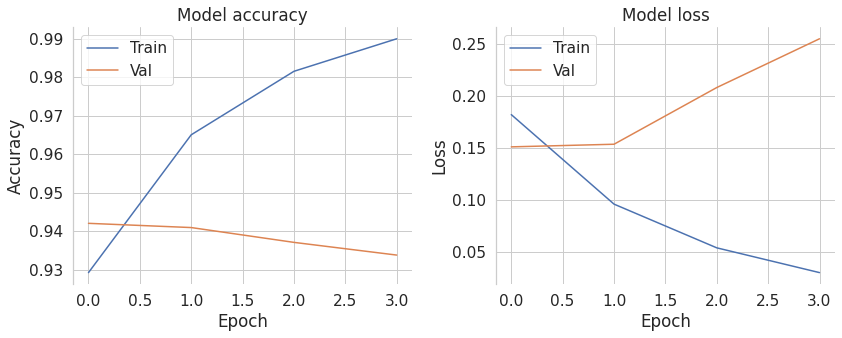

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Val'], loc='upper left')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

L'accuracy est très bonne dès les premières époques. Cependant, le modèle overfit assez vite par la suite. Ici on bat les modèles précédent (CBOW et fasttext). On pourrait tester des modèles plus avancés encore comme LSTM ou CNN.


### RNN bidirectionnels

Pour les séquences autres que les séries temporelles (par exemple, les textes), il arrive souvent qu'un modèle RNN soit plus performant s'il traite la séquence non seulement du début à la fin, mais aussi à rebours. Par exemple, pour prédire le prochain mot d'une phrase, il est souvent utile d'avoir le contexte autour du mot, et pas seulement les mots qui le précèdent.

Ici les reviews sont plutot courtes, il n'est pas sûr que le caractère bidirectionnels du LSTM soit vraiment utile.

In [11]:
from tensorflow.keras.layers import Bidirectional, LSTM


model = Sequential(name='Bi-LSTM')

# Embedding layer is learning the embedding of words
#  before feeding it to the RNN layers
model.add(Embedding(MAX_NB_WORDS, 256,
                    mask_zero=True, input_shape=[None]))

# A RNN layer can also return the entire sequence of outputs for each sample 
# (one vector per timestep per sample), if you set return_sequences=True
model.add(
    Bidirectional(LSTM(256, return_sequences=True), input_shape=(5, 10))
)
model.add(Bidirectional(LSTM(128)))
model.add(Dense(1, activation="sigmoid"))


model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

In [12]:
callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/drive/MyDrive/Projets/bi-lstm_weights.hdf5',
    save_best_only=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=4, batch_size=64, 
    callbacks=[callback], verbose=1
)

Epoch 1/4
2500/2500 [==============================] - ETA: 0s - loss: 0.2277 - accuracy: 0.9075
Epoch 1: val_loss improved from inf to 0.17529, saving model to /content/drive/MyDrive/Projets/bi-lstm_weights.hdf5
2500/2500 [==============================] - 255s 98ms/step - loss: 0.2277 - accuracy: 0.9075 - val_loss: 0.1753 - val_accuracy: 0.9330
Epoch 2/4
2500/2500 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9579
Epoch 2: val_loss improved from 0.17529 to 0.15584, saving model to /content/drive/MyDrive/Projets/bi-lstm_weights.hdf5
2500/2500 [==============================] - 241s 96ms/step - loss: 0.1149 - accuracy: 0.9579 - val_loss: 0.1558 - val_accuracy: 0.9414
Epoch 3/4
2500/2500 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9765
Epoch 3: val_loss did not improve from 0.15584
2500/2500 [==============================] - 242s 97ms/step - loss: 0.0689 - accuracy: 0.9765 - val_loss: 0.1714 - val_accuracy: 0.9387
Epoch 4/4
2500/250

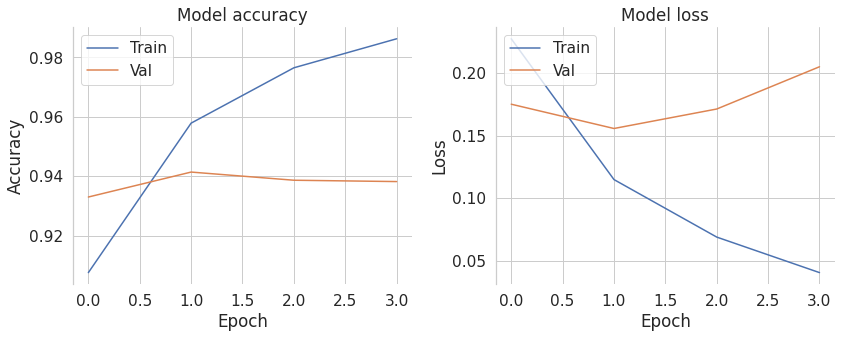

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Val'], loc='upper left')

# Finalize the plot
sns.despine(bottom=True)
plt.tight_layout(h_pad=2)

Un modèle plus complexe comme ce LSTM bidirectionnel ne semble pas avoir améliorer l'accuracy de notre GRU intial. Cela tient probablement au fait que nos reviews sont des documents de taille limitée et que ceux-ci ne requièrent pas nécessairement de composante bidirectionnelle.

A niveau d'accuracy similaire, autant retenir le modèle le plus léger et le moins gourmand en terme de ressources.

Voyons donc le temps moyen d'une prédiction avec notre modèle GRU standard.

In [20]:
import time

model.load_weights('/content/drive/MyDrive/Projets/rnn_weights.hdf5')
times = []

for i in range(500):
    x = np.array([X_test[i], ])
    t0 = time.time()
    y_pred = model.predict(x)
    t1 = time.time()
    times.append(t1 - t0)

In [21]:
times = pd.Series(times*1000)
print('Inférence times in ms:')
times.describe(percentiles=[.25, .50, .75, 0.95])

Inférence times in ms:


count    500000.000000
mean          0.043329
std           0.006226
min           0.035179
25%           0.039028
50%           0.041778
75%           0.046024
95%           0.053677
max           0.096291
dtype: float64